Minimal yield in the training data set = 0.6836461126005362
Mean yield in the training data set = 0.887043001169419
Max yield in the training data set = 0.9773347324239244


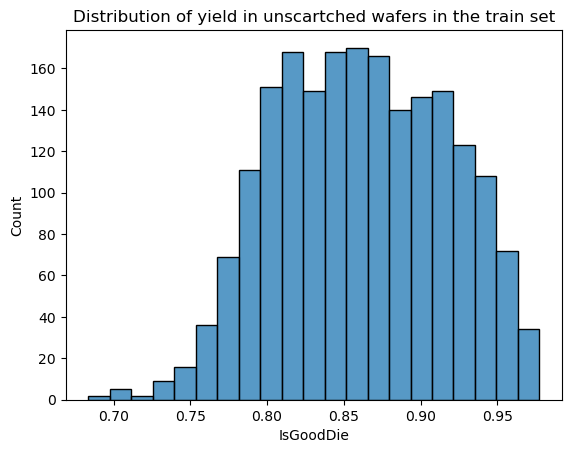

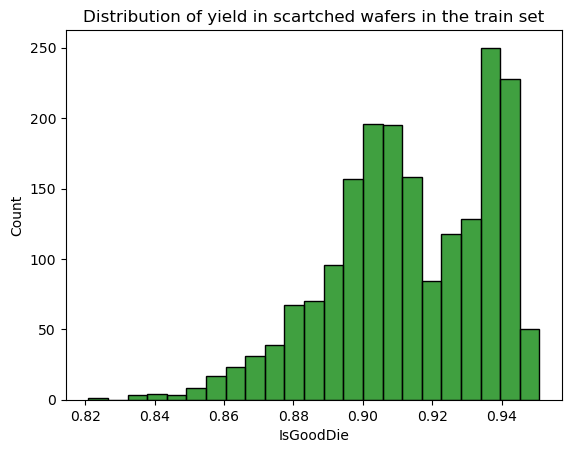

Minimal yield in the test set = 0.7184986595174263
Mean yield in the test set = 0.8892529525178114
Max yield in the test set = 0.9782747603833866


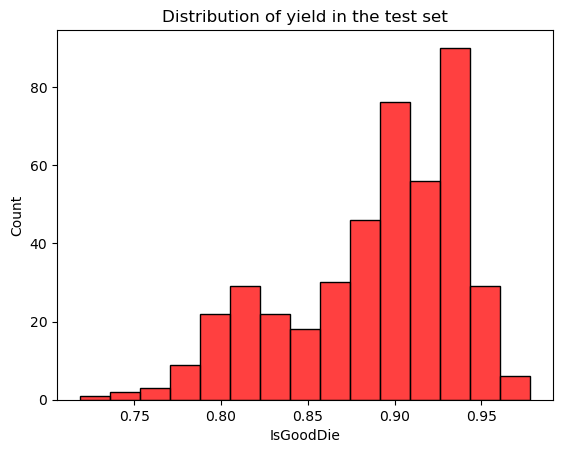

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import transforms
pd.options.mode.chained_assignment = None
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to resize tensors to a uniform size of 128x128 which is bigger than the biggest wafer of 105x105
def convert_to_128_128(dataset):
    transformed_tensors = []
    for tensor in dataset:
        temp = tensor.unsqueeze(0).unsqueeze(0)
        transformed_tensors.append(F.interpolate(temp, size=(128, 128), mode='bilinear', align_corners=False))
    return transformed_tensors

# Function to convert a list of tensors into a stacked tensor
def convert_list_to_stack(lst):      
    return torch.stack(lst).squeeze(1)  

# Function to return predictions to a DF with Diex & DieY
def ndarray_to_dataframe(array):
    # Get the shape of the array
    rows, cols = array.shape
    
    # Enumerate through the array and create a list of dictionaries
    data = [{'DieX': i, 'DieY': j, 'IsScratchDie': array[i, j]} for (i, j), value in np.ndenumerate(array)]
    
    # Create the DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    
    return df

# Calculate AUC
def calculate_auc(y_true, y_pred):
    # Check if all predicted classes are the same
    if len(set(y_true)) == 1:
        return 0

    # Calculate AUC using roc_auc_score function from scikit-learn
    auc = roc_auc_score(y_true, y_pred)
    return auc

# Load the dataframes
df_wafers = pd.read_csv('/kaggle/input/datasets2/df_wafers.csv')
df_wafers_test = pd.read_csv('/kaggle/input/datasets2/df_wafers_test.csv')

# Calculate statistics for training data
number_of_dies_on_wafer = df_wafers.groupby('WaferName')['IsGoodDie'].count()
good_dies_per_wafer = df_wafers.groupby('WaferName')['IsGoodDie'].sum()
bad_dies_per_wafer = number_of_dies_on_wafer - good_dies_per_wafer
good_percent = good_dies_per_wafer / number_of_dies_on_wafer
print("Minimal yield in the training data set = " + str(np.min(good_percent)))
print("Mean yield in the training data set = " + str(np.mean(good_percent)))
print("Max yield in the training data set = " + str(np.max(good_percent)))

# Calculate statistics for filtering wafers with too many bad dies
# Separate wafers with and without scratches
scratch_dies = df_wafers[df_wafers['WaferName'].isin(good_percent.index)].groupby('WaferName')['IsScratchDie'].sum()
has_no_scratched_dies = scratch_dies[scratch_dies == 0]
has_scratched_dies = scratch_dies[scratch_dies > 0]
has_no_scratched_dies = df_wafers[df_wafers['WaferName'].isin(has_no_scratched_dies.index)]
has_scratched_dies = df_wafers[df_wafers['WaferName'].isin(has_scratched_dies.index)]

# Histograms of yield for wafers with and without scratches
stats_wafers_without_scratches = good_percent[good_percent.index.isin(has_no_scratched_dies.WaferName)]
sns.histplot(stats_wafers_without_scratches)
plt.title('Distribution of yield in unscartched wafers in the train set')
plt.show()
stats_wafers_with_scratches = good_percent[good_percent.index.isin(has_scratched_dies.WaferName)]
sns.histplot(stats_wafers_with_scratches, color='green')
plt.title('Distribution of yield in scartched wafers in the train set')
plt.show()
#minimal yield perecentage of wafers with a classified scratche is slightly above 82%.
## Therefore wafers with a yield <=82% will not be checked for scratches

# Filter wafers based on yield cutoff (82%)
filtered_wafers = good_percent[good_percent > 0.82]
train_df = df_wafers[df_wafers['WaferName'].isin(filtered_wafers.index)]

# # Calculate statistics for test data
test_number_of_dies_on_wafer = df_wafers_test.groupby('WaferName')['IsGoodDie'].count()
test_good_dies_per_wafer = df_wafers_test.groupby('WaferName')['IsGoodDie'].sum()
test_good_percent = test_good_dies_per_wafer / test_number_of_dies_on_wafer
print("Minimal yield in the test set = " + str(np.min(test_good_percent)))
print("Mean yield in the test set = " + str(np.mean(test_good_percent)))
print("Max yield in the test set = " + str(np.max(test_good_percent)))

# Histogram of yield for the test set
sns.histplot(test_good_percent, color='red')
plt.title('Distribution of yield in the test set')
plt.show()

# Apply threshold on the test set
filtered_test_wafers = test_good_percent[test_good_percent > 0.82]
low_yield_therefore_no_labeling = test_good_percent[test_good_percent <= 0.82]
test_df = df_wafers_test[df_wafers_test['WaferName'].isin(filtered_test_wafers.index)]
df_wafers_test.loc[df_wafers_test['WaferName'].isin(low_yield_therefore_no_labeling.index), 'IsScratchDie'] = False

# Convert training data to tensors
# data_wafers_as_tensors = []
# targets_wafers_as_tensors = []
# for wafer in train_df.WaferName.unique():
#     wafer_df = train_df.loc[train_df['WaferName'] == wafer]
#     data = torch.from_numpy(~wafer_df.pivot(index='DieX', columns='DieY', values='IsGoodDie').values.astype(bool))
#     targets = torch.from_numpy(wafer_df.pivot(index='DieX', columns='DieY', values='IsScratchDie').values.astype(bool))
#     data_wafers_as_tensors.append(data)
#     targets_wafers_as_tensors.append(targets)
# torch.save(data_wafers_as_tensors, 'data_wafers_as_tensors.pt')
# torch.save(targets_wafers_as_tensors, 'targets_wafers_as_tensors.pt')

# Convert test data to tensors
# data_test_wafers_as_tensors = []
# for wafer in test_df.WaferName.unique():
#     wafer_df = test_df.loc[test_df['WaferName']== wafer]
#     data = torch.from_numpy(~wafer_df.pivot(index='DieX', columns='DieY', values='IsGoodDie').values.astype(bool))
#     data_test_wafers_as_tensors.append(data)
# print(len(data_test_wafers_as_tensors)) #
# torch.save(data_test_wafers_as_tensors, 'data_test_wafers_as_tensors.pt')

# Load tensors
data_wafers_as_tensors = torch.load('/kaggle/input/datasets2/data_wafers_as_tensors.pt')
targets_wafers_as_tensors = torch.load('/kaggle/input/datasets2/targets_train_wafers_as_tensors.pt')
data_test_wafers_as_tensors = torch.load('/kaggle/input/datasets2/data_test_wafers_as_tensors.pt')

# Convert tensors to float
data_wafers_as_tensors = [torch.tensor(cv2.flip(tensor.float().numpy(), 1).T) for tensor in data_wafers_as_tensors]
targets_wafers_as_tensors = [torch.tensor(cv2.flip(tensor.float().numpy(), 1).T) for tensor in targets_wafers_as_tensors]
data_test_wafers_as_tensors = [torch.tensor(cv2.flip(tensor.float().numpy(), 1).T) for tensor in data_test_wafers_as_tensors]

ind_num = []
index_list = []
train_set_with_scratches = []
target_train_set_with_scratches = []
for i in range(len(targets_wafers_as_tensors)):
    if targets_wafers_as_tensors[i].any():
        ind_num.append(i)
        index_list.append(True)
        train_set_with_scratches.append(data_wafers_as_tensors[i])
        target_train_set_with_scratches.append(targets_wafers_as_tensors[i])
    else:
        index_list.append(False)


# Resize tensors to a uniform size of 128x128 
resized_data_wafers_as_tensors = convert_to_128_128(train_set_with_scratches)
resized_targets_wafers_as_tensors = convert_to_128_128(target_train_set_with_scratches)


#Split the data into train and validation sets (~80%/20% split)
lim = np.ceil(len(train_set_with_scratches)*0.8).astype(int)
train_set_ind = ind_num[:lim]
train_set = convert_list_to_stack(resized_data_wafers_as_tensors[:lim])
target_train_set = convert_list_to_stack(resized_targets_wafers_as_tensors[:lim])
validation_set_ind = ind_num[lim:]
validation_set = convert_list_to_stack(resized_data_wafers_as_tensors[lim:])
target_validation_set = convert_list_to_stack(resized_targets_wafers_as_tensors[lim:])

'97a213'

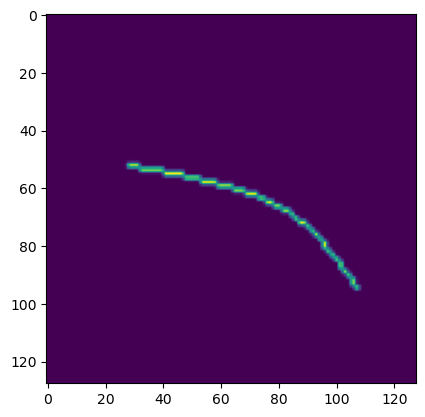

In [81]:
plt.imshow((target_validation_set[0]).squeeze())
target_validation_set.size()
validation_set_ind[0]
train_df.WaferName[1541]
#plt.imshow(target_train_set_with_scratches[1541])
#target_train_set_with_scratches[1541].shape

Epoch 1/384, Train Loss: 0.0408, Val Loss: 0.0214
Epoch 2/384, Train Loss: 0.0345, Val Loss: 0.0196
Epoch 3/384, Train Loss: 0.0334, Val Loss: 0.0190
Epoch 4/384, Train Loss: 0.0325, Val Loss: 0.0185
Epoch 5/384, Train Loss: 0.0318, Val Loss: 0.0179
Epoch 6/384, Train Loss: 0.0314, Val Loss: 0.0175
Epoch 7/384, Train Loss: 0.0310, Val Loss: 0.0178
Epoch 8/384, Train Loss: 0.0307, Val Loss: 0.0172
Epoch 9/384, Train Loss: 0.0304, Val Loss: 0.0172
Epoch 10/384, Train Loss: 0.0301, Val Loss: 0.0169
Epoch 11/384, Train Loss: 0.0300, Val Loss: 0.0177
Epoch 12/384, Train Loss: 0.0297, Val Loss: 0.0186
Epoch 13/384, Train Loss: 0.0295, Val Loss: 0.0164
Epoch 14/384, Train Loss: 0.0294, Val Loss: 0.0160
Epoch 15/384, Train Loss: 0.0292, Val Loss: 0.0162
Epoch 16/384, Train Loss: 0.0291, Val Loss: 0.0158
Epoch 17/384, Train Loss: 0.0290, Val Loss: 0.0159
Epoch 18/384, Train Loss: 0.0289, Val Loss: 0.0155
Epoch 19/384, Train Loss: 0.0288, Val Loss: 0.0156
Epoch 20/384, Train Loss: 0.0286, Val Lo

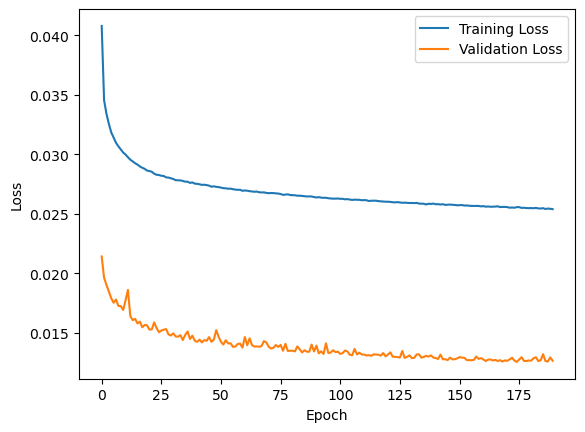

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def  __getitem__(self, index):
        data_sample = self.data[index]
        target_sample = self.targets[index]
        return data_sample, target_sample

# Define the neural network model with dropout
class PixelClassifier(nn.Module):
    def __init__(self):
        super(PixelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=9, stride=1, padding=4)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define the training loop with early stopping
def train(model, train_loader, val_loader, criterion, optimizer, patience=5, max_epochs=100):
    train_losses = []  # List to store training loss values
    val_losses = []  # List to store validation loss values
    auc_scores = []  # List to store auc scores values
    best_val_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.float()
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                probabilities = torch.sigmoid(outputs)
                val_predictions.append(probabilities.detach().cpu().numpy().astype('float'))
                val_targets.append(targets.cpu().numpy())

        val_loss /= len(val_loader)
# Append the losses to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}...")
                break

    print(f"Best model obtained at epoch {best_epoch+1}")

# Plotting the training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_roc_curve(targets, predictions):
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    auc_score = roc_auc_score(targets, predictions)

    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

# Dataset Setup
train_dataset = CustomDataset(train_set, target_train_set)  
val_dataset = CustomDataset(validation_set, target_validation_set)  

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = PixelClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) #learning rate is a high to speed training w/low resources

train(model, train_loader, val_loader, criterion, optimizer, patience=15, max_epochs=384)

# Experimenting With Kernel sizes
### Kernels' sizes 1:7X7; 2:5X5
### Output has a lower AUC

In [ ]:
#Experimenting With Kernel sizes 1:7X7; 2:5X5
class PixelClassifier(nn.Module):
    def __init__(self):
        super(PixelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model = PixelClassifier().to(device)    
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05) #learning rate is high to speed training w/low resources
train(model, train_loader, val_loader, criterion, optimizer, patience=5, max_epochs=384)

### Kernels' sizes 1:5X5; 2:5X5

In [ ]:
#Experimenting With Kernels' sizes 1:5X5; 2:5X5
class PixelClassifier(nn.Module):
    def __init__(self):
        super(PixelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model = PixelClassifier().to(device)    
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05) #learning rate is high to speed training w/low resources
train(model, train_loader, val_loader, criterion, optimizer, patience=5, max_epochs=384)

### Kernels' sizes 1:3X3; 2:3X3

In [ ]:
#Experimenting With Kernels' sizes 1:3X3; 2:3X3
class PixelClassifier(nn.Module):
    def __init__(self):
        super(PixelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model = PixelClassifier().to(device)    
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05) #learning rate is high to speed training w/low resources
train(model, train_loader, val_loader, criterion, optimizer, patience=5, max_epochs=384)

Kernels' sizes 1:3X3; 2:3X3

In [ ]:
#Experimenting With Kernels' sizes 1:3X3; 2:3X3
class PixelClassifier(nn.Module):
    def __init__(self):
        super(PixelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
model = PixelClassifier().to(device)    
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.25) #learning rate is high to speed training w/low resources
train(model, train_loader, val_loader, criterion, optimizer, patience=5, max_epochs=384)

# Prediction

In [83]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def  __getitem__(self, index):
        data_sample = self.data[index]
        return data_sample


def predict(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    
    predictions = []
    
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.float()
            inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU) if available
            outputs = (np.squeeze(torch.sigmoid(model(inputs))))>0.5
            predictions.append(outputs.cpu().numpy())  # Convert predictions to numpy array
    return predictions

#convert wafers to images
data_test_wafers_as_tensors = torch.load('/kaggle/input/datasets2/data_test_wafers_as_tensors.pt')
data_test_wafers_as_tensors = [torch.tensor(cv2.flip(tensor.float().numpy(), 1).T) for tensor in data_test_wafers_as_tensors]
data_test_wafers_as_tensors_128X128 = convert_to_128_128(data_test_wafers_as_tensors)
test_set = convert_list_to_stack(data_test_wafers_as_tensors_128X128)

#create test set
test_dataset = CustomDataset(test_set)  
testing_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
results = predict(model, testing_loader)

#resize back to original wafer size
def resize_to_square(image, size):
    """
    Resize a single image to a square size using bilinear interpolation.
    
    Args:
        image (np.ndarray): The input image as a NumPy ndarray.
        size (int): The desired square size for the resized image.
    
    Returns:
        np.ndarray: The resized image as a NumPy ndarray.
    """
    temp = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
    resized_tensor = F.interpolate(temp, size=(size, size), mode='bilinear', align_corners=False)
    return resized_tensor.squeeze().numpy()

from sklearn.metrics import roc_auc_score

#Get AUC score
def auc_score(targets, predictions):
    #fpr, tpr, thresholds = roc_curve(targets, predictions)
    auc_score = roc_auc_score(targets, predictions)
    return auc_score

#create predicitons, resize them back to the original size, and parse back to the original DF
def pred_pipeline(results, data_test_wafers_as_tensors, test_df):
    wafer_names = df_wafers_test.WaferName.unique()
    for i in range(len(results)):
        temp = resize_to_square(results[i], data_test_wafers_as_tensors[i].size()[0])
        mask = df_wafers_test.WaferName == wafer_names[i]
        temp_df = ndarray_to_dataframe(temp)
        joined_df = df_wafers_test[mask].join(temp_df.set_index(['DieX', 'DieY']), on=['DieX', 'DieY'], rsuffix='_y')
        df_wafers_test.loc[mask, "IsScratchDie"] = joined_df["IsScratchDie_y"]>0.5
        
pred_pipeline(results, data_test_wafers_as_tensors, test_df)

In [86]:
df_wafers_test.IsScratchDie.value_counts()
df_wafers_test.to_csv('df_wafers_test_with_preds.csv')

# AUC of best model:
### AUC-ROC score is the tradeoff between Recall (True Positive Rate), and the False Positive Rate.
I choose this metric because every mistake cost some amount of money, whether it is because a good chip ("die") was killed unnecessarily or because a bad die was not killed and will cause some issue further down the chain.

In theory, given these cost, a formula can be made to calculate the best balance between killing too many dies (too many false positive) or not killing enough dies (too little true positive). Thus fitting the model to the most profitiable balance.

In [79]:
validation_dataset = CustomDataset(validation_set)  
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
results = predict(model, validation_loader)
results_array = np.concatenate(results)
targets_flat = np.squeeze(target_validation_set).reshape(-1)>0.85
predictions_flat = np.squeeze(results_array).reshape(-1)
auc_score(targets_flat, predictions_flat)

0.8151412818490501

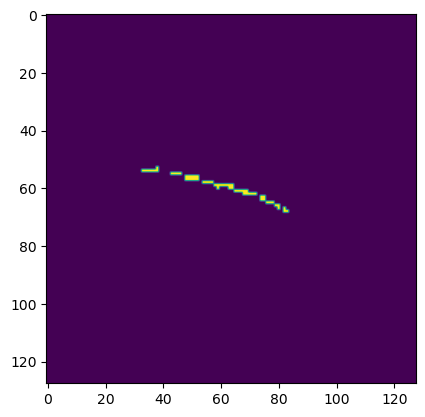

In [80]:
#prediciton example
plt.imshow(results[0].squeeze())

In [5]:
#saved model with trained weights
model = PixelClassifier().to(device)
state_dict = torch.load('/kaggle/input/datasets2/checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [21]:
checkpoint = {'model': Classifier(),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')